# Promising Sectors Selection

In [1]:
import pandas as pd
from functools import reduce

def loadYearlyData(year):
    path = '//172.26.1.102/dstore/uncomtrade/annual_reduced/'
    df = pd.read_csv(path + str(year) + '.csv', header=0,
                     names=['flow', 'reporter', 'partner', 'commodity', 'val'],
                     dtype={'flow': int,
                            'reporter': int,
                            'partner': int,
                            'commodity': str,
                            'val': float})
    # Keep only import data (flow == 1)
    df = df[df['flow'] == 1].drop('flow', axis=1)
    # Get HS6 rows and pad 0's to have length 6
    df = df[df['commodity'].str.len() >= 5]
    df['commodity'] = df['commodity'].apply(lambda x: x.zfill(6))
    # Add year column
    df['year'] = year
    return df

df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True),
            map(loadYearlyData, range(2012, 2016)))

In [2]:
import numpy as np

xl = pd.read_excel('C:/Users/2093/Desktop/Data Center/03. Data/01. HS_code/HS_code_groups/\
拓展處選擇產業聯盟/聯盟選擇產業-數據中心0215.xlsx', sheetname=None)

def extractCodes(x):
    return x.astype(str).apply(lambda x: x[:6]).unique()

hardware  = extractCodes(xl['水五金']['HS code'])
socks     = extractCodes(xl['織襪']['HS 6碼'])
lifestyle = extractCodes(xl['生活用品(含家電、資通訊產品)']['HS 6碼'][:260])
appliance = extractCodes(xl['生活用品(含家電、資通訊產品)']['HS 6碼'][265:])
lifeappli = np.unique(np.append(lifestyle, appliance))
sport     = extractCodes(xl['運動用品']['HS 6碼'])

sectors = ['hardware', 'socks', 'lifestyle', 'lifeappli', 'sport']

In [3]:
def computeStats(data, sector):
    sec = eval(sector)
    sector_sum = data[(data['partner'] == 0) & (
            data['commodity'].str.contains('^' + '|'.join(sec)))].groupby('year').agg({'val': 'sum'})
    sector_sum_tw = data[(data['partner'] == 490) & (
            data['commodity'].str.contains('^' + '|'.join(sec)))].groupby('year').agg({'val': 'sum'})
    rs = pd.concat([sector_sum_tw,
                    sector_sum,
                    sector_sum_tw / sector_sum * 100], axis=1)
    rs.columns = ['import_tw', 'import_ttl', 'tw_share']
    rs['sector'] = sector
    return rs

rs = reduce(lambda x, y: pd.concat([x, y], axis=0), map(lambda x: computeStats(df, x), sectors))

In [4]:
# Compute growth rates
rs['growth_tw'] = (rs['import_tw'] - rs.groupby('sector')['import_tw'].shift(1)
    ) / rs.groupby('sector')['import_tw'].shift(1) * 100
rs['growth_ttl'] = (rs['import_ttl'] - rs.groupby('sector')['import_ttl'].shift(1)
    ) / rs.groupby('sector')['import_ttl'].shift(1) * 100
rs.index = pd.to_datetime(rs.index, format='%Y')

## Part 1: Import Value (Relative Size)

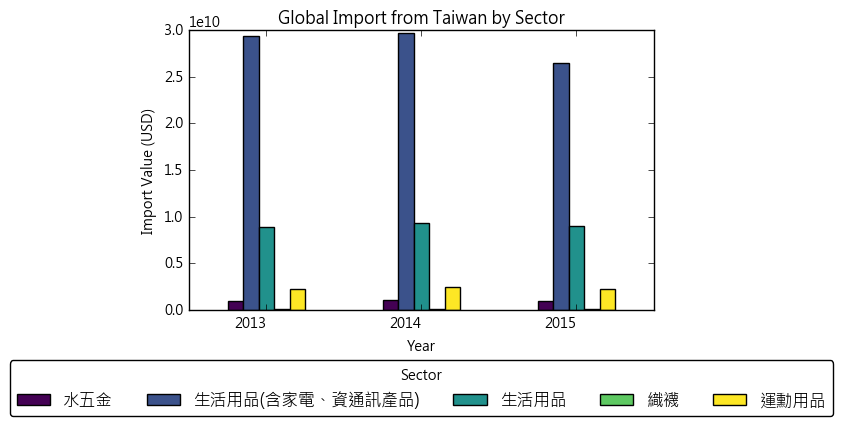

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.clf()
ax = pd.pivot_table(rs.loc[rs.index != pd.to_datetime('2012-01-01'),
                           ['sector', 'import_tw']].reset_index(),
                    values='import_tw', index='year', columns='sector').plot(
    kind='bar', title='Global Import from Taiwan by Sector', colormap='viridis')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(['2013', '2014', '2015']))
plt.gcf().autofmt_xdate(rotation=0)
plt.xlabel('Year')
plt.ylabel('Import Value (USD)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=False, ncol=5,
           title='Sector', labels=['水五金', '生活用品(含家電、資通訊產品)', '生活用品', '織襪', '運勳用品'])
plt.show()

## Part 2: Global Market Share (Comparison of Sectors)

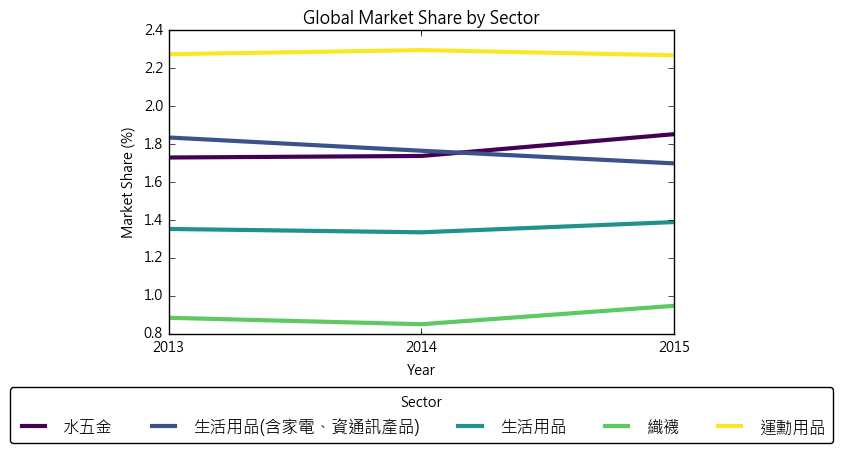

In [6]:
plt.clf()
fig, ax = plt.subplots()
pd.pivot_table(rs.loc[rs.index != pd.to_datetime('2012-01-01')].reset_index()[
    ['year', 'sector', 'tw_share']], values='tw_share', index='year', columns='sector').plot(
    ax=ax, title='Global Market Share by Sector', colormap='viridis', linewidth=3)
plt.xlabel('Year')
plt.ylabel('Market Share (%)')
plt.tight_layout()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=5,
          title='Sector', labels=['水五金', '生活用品(含家電、資通訊產品)', '生活用品', '織襪', '運勳用品'])
plt.show()

## Part 3: Annual % Growth of Import (from Taiwan vs. from World)

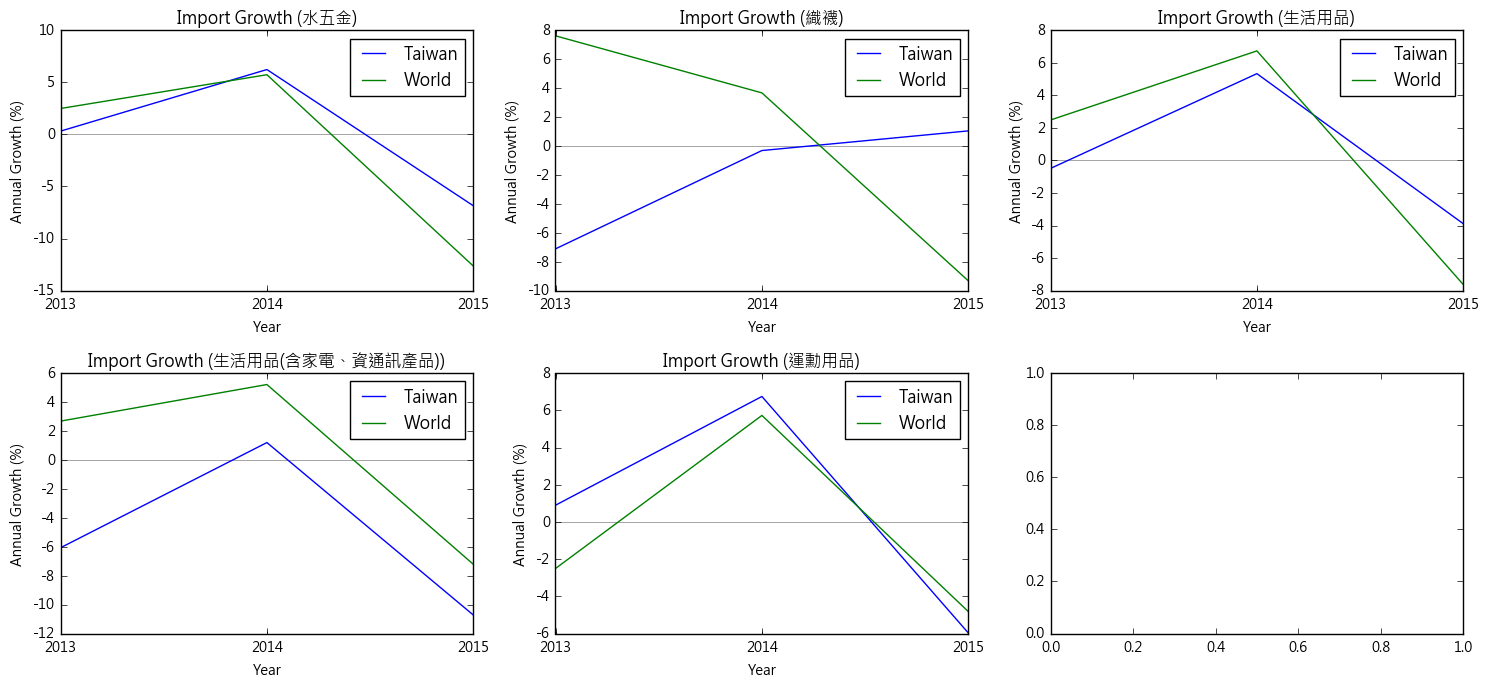

In [7]:
plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
for sector, ax, ttl in zip(rs.loc[rs.index != pd.to_datetime('2012-01-01')]['sector'].unique(),
                           axes.flatten()[:-1],
                           ['水五金', '織襪', '生活用品', '生活用品(含家電、資通訊產品)', '運勳用品']):
    rs.loc[(rs.index != pd.to_datetime('2012-01-01')) & (rs['sector'] == sector)][
        ['growth_tw', 'growth_ttl']].plot(ax=ax, title=sector)
    ax.axhline(y=0, c='grey', linewidth=0.5, zorder=0)
    ax.set_title('Import Growth ({})'.format(ttl))
    ax.set_xlabel('Year')
    ax.set_ylabel('Annual Growth (%)')
    ax.legend(labels=['Taiwan', 'World'])
plt.tight_layout()
plt.show()

## Part 4: Putting It Together (Import Value, Market Share, Growth)

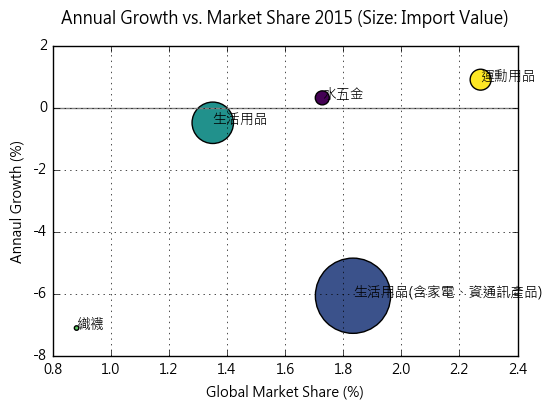

In [8]:
import matplotlib.cm as cm

dt = rs.loc['2013'][['sector', 'import_tw', 'tw_share', 'growth_tw']]

plt.clf()
cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 5))[[0, 3, 2, 1, 4], :]
plt.scatter(dt['tw_share'], dt['growth_tw'], s=dt['import_tw']/1e7, c=colors)
for i in range(5):
    plt.annotate(['水五金', '織襪', '生活用品', '生活用品(含家電、資通訊產品)', '運勳用品'][i],
                 xy=(dt['tw_share'][i], dt['growth_tw'][i]))
plt.axhline(y=0, c='grey')
plt.title('Annual Growth vs. Market Share 2015 (Size: Import Value)', y=1.05)
plt.xlabel('Global Market Share (%)')
plt.ylabel('Annaul Growth (%)')
plt.grid(True)
plt.show()

## Part 5: Output Data

In [9]:
# Compute average growth rates
rs['growth_tw_mean'] = rs.groupby('sector')['growth_tw'].transform('mean')
rs['growth_ttl_mean'] = rs.groupby('sector')['growth_ttl'].transform('mean')

In [10]:
rs[['sector', 'import_tw', 'import_ttl', 'tw_share', 'growth_tw', 'growth_tw_mean',
    'growth_ttl', 'growth_ttl_mean']].to_csv('sector_stats.csv')